## Imports

In [15]:
import torch
from torch.utils.data import DataLoader
from data import ParenthesizationDataset, parenthesization_to_tensor, padding_mask
from model import Model
from train import train_one_epoch, compute_validation_loss
from evaluate import evaluate_model, predict
from interpret import plot_linear_layer, incorrect_predictions, token_contributions, collect_activations
import matplotlib.pyplot as plt
import parenthesizations
import numpy as np

## Initialize model, loaders, loss function, optimizer
`checkpoint_epochs` is the number of epochs before a checkpoint is saved. Use `data_prefix` to choose the "small" dataset.

In [16]:
epochs = 30
checkpoint_epochs = 2
batch_size = 64
d_model = 16
nhead = 4
num_layers = 1
n_vocab = 4
#data_prefix = ""
data_prefix = "small_"

training_dataset = ParenthesizationDataset(f"{data_prefix}training")
validation_dataset = ParenthesizationDataset(f"{data_prefix}validation")
test_dataset = ParenthesizationDataset(f"{data_prefix}test")

training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = Model(n_vocab, d_model, nhead, num_layers)
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train model
`start_epoch` can be set to a value greater than 0 to resume training from a checkpoint.

In [17]:
start_epoch = 29

training_loss = []
validation_loss = []
best_validation_loss = float("inf")

def save():
    torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'training_loss': training_loss,
      'validation_loss': validation_loss
    }, f"checkpoints/epoch_{epoch}.pth")

def resume(epoch):
    global training_loss, validation_loss
    checkpoint = torch.load(f"checkpoints/epoch_{epoch}.pth")
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    training_loss = checkpoint["training_loss"]
    validation_loss = checkpoint["validation_loss"]

if start_epoch > 0:
    resume(start_epoch)
    start_epoch += 1

for epoch in range(start_epoch, epochs):
    model.train(True)
    training_loss.append(train_one_epoch(training_loader, model, loss_fn, optimizer))
    validation_loss.append(compute_validation_loss(validation_loader, model, loss_fn))
    print(f"Epoch {epoch}, Training Loss {training_loss[-1]}, Validation Loss {validation_loss[-1]}")

    if (epoch+1) % checkpoint_epochs == 0:
        save()

# Plot the loss curve for training and validation

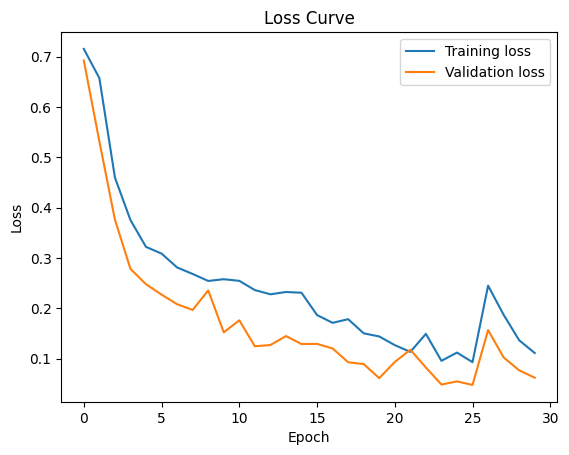

In [4]:
# Plot loss function
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

# Evaluate the model and plot the confusion matrix

C:\Users\ptwel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ..\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training data set accuracy:
Accuracy for class 0 = 96.22411693057248%
Accuracy for class 1 = 95.86374695863746%
Overall accuracy = 96.0438222763238%


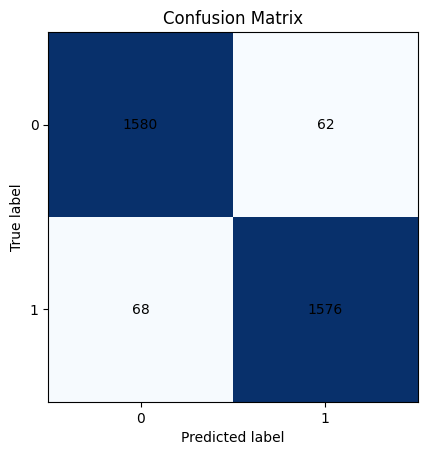

Validation data set accuracy:
Accuracy for class 0 = 98.03921568627452%
Accuracy for class 1 = 99.01960784313725%
Overall accuracy = 98.52941176470588%


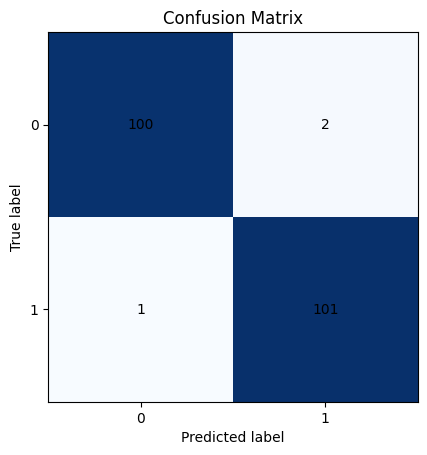

Test data set accuracy:
Accuracy for class 0 = 95.45454545454545%
Accuracy for class 1 = 97.07792207792208%
Overall accuracy = 96.26623376623377%


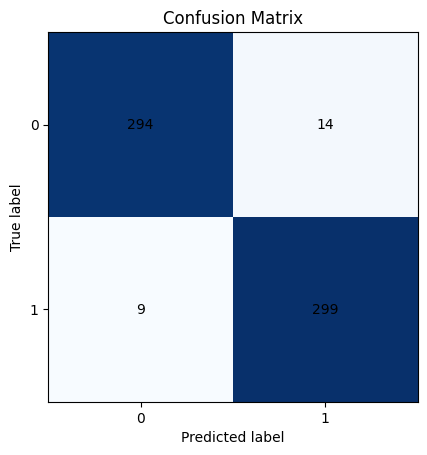

In [5]:
training_confusion_matrix = evaluate_model(model, training_loader)
validation_confusion_matrix = evaluate_model(model, validation_loader)
test_confusion_matrix = evaluate_model(model, test_loader)

print("Training data set accuracy:")
training_confusion_matrix.print_accuracy()
training_confusion_matrix.plot()

print("Validation data set accuracy:")
validation_confusion_matrix.print_accuracy()
validation_confusion_matrix.plot()

print("Test data set accuracy:")
test_confusion_matrix.print_accuracy()
test_confusion_matrix.plot()

# Interpretation
In this section you will try various techniques to interpret the model. Insert additional notebook cells as need to do the following:

1. Construct some test cases of varying lengths and display the model's predictions.
2. Compute the list of incorrect predictions and display some examples of them.
3. For each incorrect prediction, plot the token contributions as a heatmap.
4. For each position from 0 to 21, loop over all inputs in the test set and plot a histogram of the token contributions for that position.
5. Plot the heatmap for the projection layer and the second linear layer in the feedforward.
6. Loop over all inputs in the test set and count the activations in the feedforward layer. Plot the activations as a histogram to see which features in the feedforward layer are activated the most.

#1 Test Cases For Displaying Models Predictions

In [6]:
# Define test cases of varying lengths
test_cases = [
    "(()))))))))",               
    "(((())))))((()))",     
    "((())(())",           
    "(((()))(()",          
    "(((((",                
    "(()(()))()((()))",  
     "()()()()((((", 
     "(()())(()))"


]

# Convert test cases to tensor format
test_tensors = [parenthesization_to_tensor(case) for case in test_cases]

# Ensure the model is in evaluation mode
model.eval()

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Convert test tensors to a batch
test_batch = torch.stack(test_tensors).to(device)

# Get padding mask for the batch
test_mask = padding_mask(test_batch).to(device)

# Make predictions
with torch.no_grad():
    outputs = model(test_batch, mask=test_mask)
    # Use the CLS token's output for the prediction
    cls_outputs = outputs[:, 0, :]  # Assuming the CLS token is the first token in each sequence
    _, predicted = torch.max(cls_outputs, 1)  # Extract class indices from CLS token outputs
    
# Display the predictions
for i, case in enumerate(test_cases):
    print(f"Test case: {case}")
    print(f"Predicted label: {predicted[i].item()}")
    print()


Test case: (()))))))))
Predicted label: 0

Test case: (((())))))((()))
Predicted label: 0

Test case: ((())(())
Predicted label: 1

Test case: (((()))(()
Predicted label: 0

Test case: (((((
Predicted label: 0

Test case: (()(()))()((()))
Predicted label: 1

Test case: ()()()()((((
Predicted label: 0

Test case: (()())(()))
Predicted label: 1



#2 Incorrect Predictions Results

In [18]:

# Call the function and print results
incorrect_preds = incorrect_predictions(model, test_loader)

 #Print the results
for label, incorrect in enumerate(incorrect_preds):
    print(f"Incorrect predictions for label {label}:")
    
    for inp in incorrect:
        print(inp)

print(f"Number of incorrect predictions: {len(incorrect)}")


Total number of parentheses evaluated: 9464
Incorrect predictions for label 0:
[2, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 3, 3, 3,

#3 Displays 20 Heatmaps of the Token Contributions 

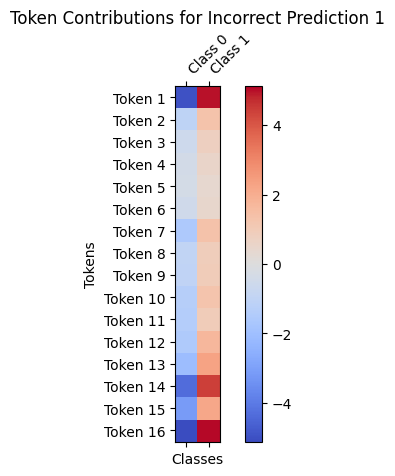

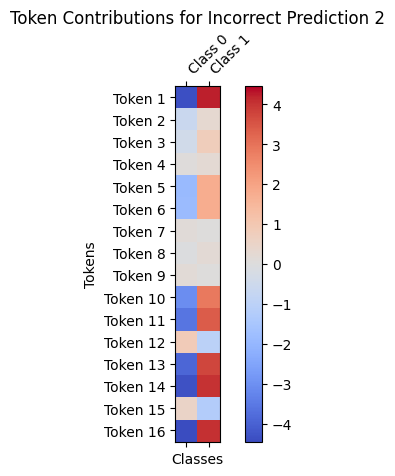

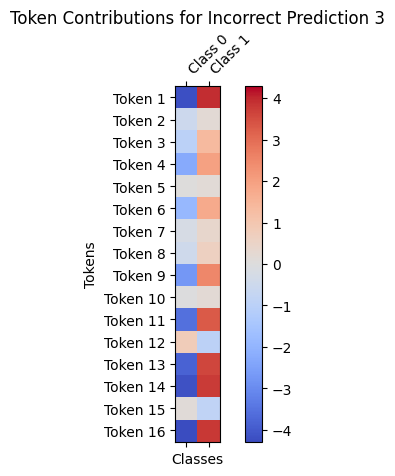

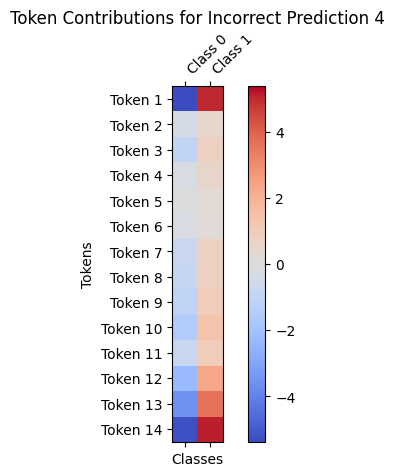

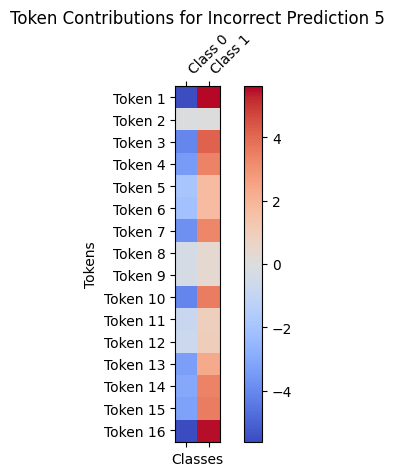

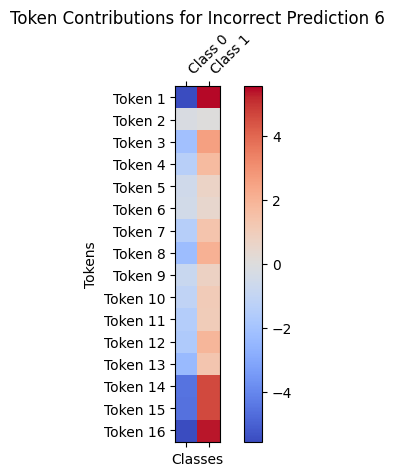

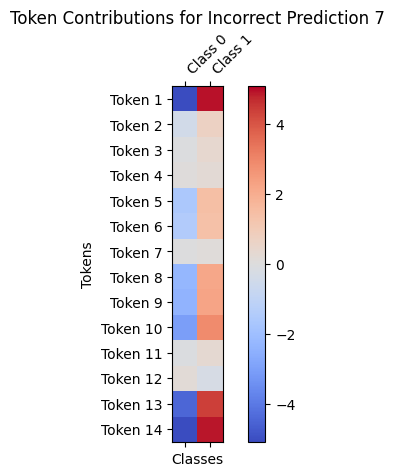

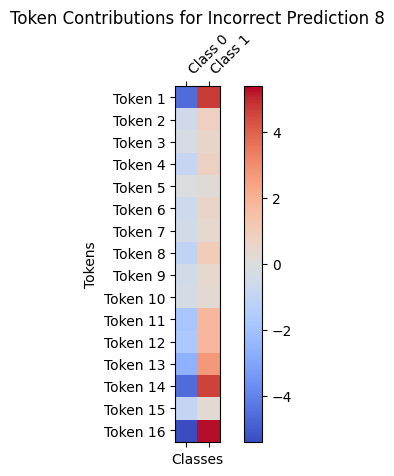

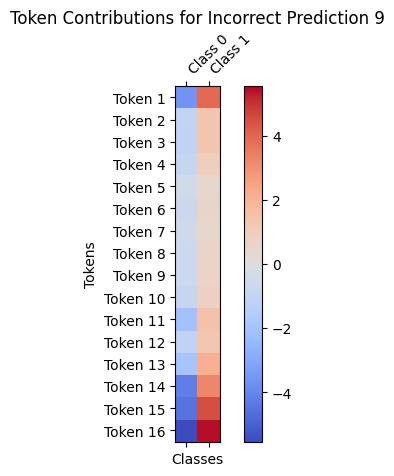

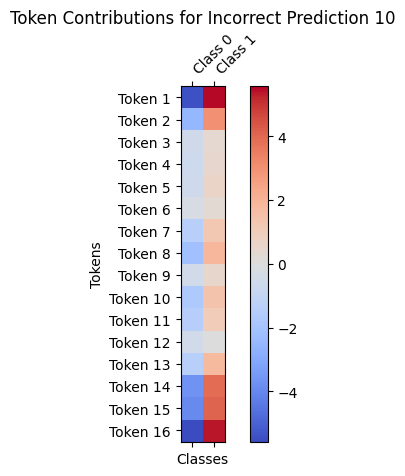

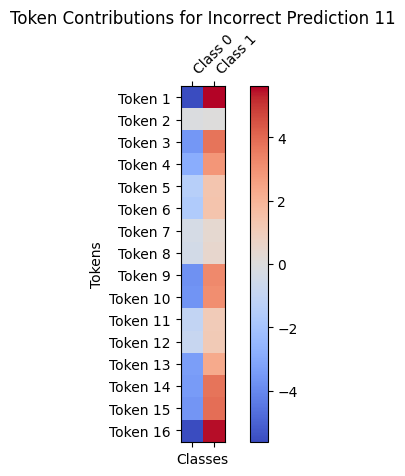

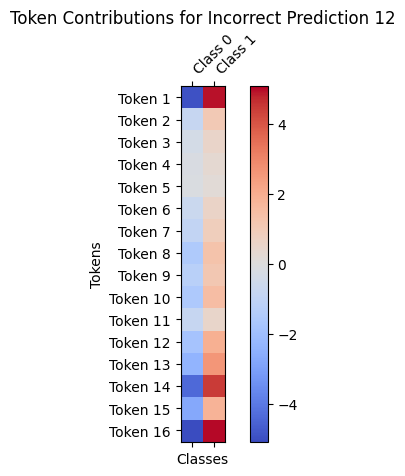

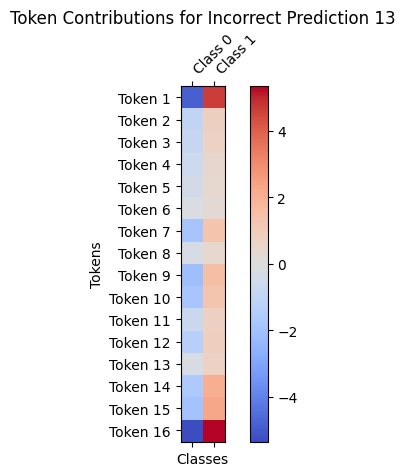

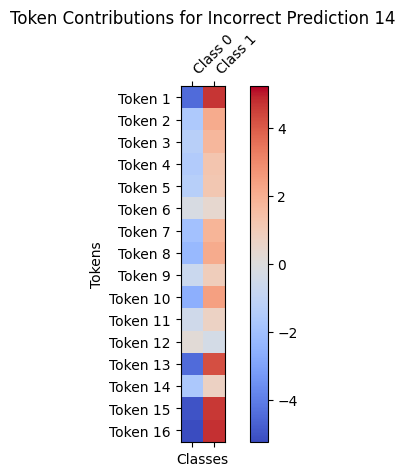

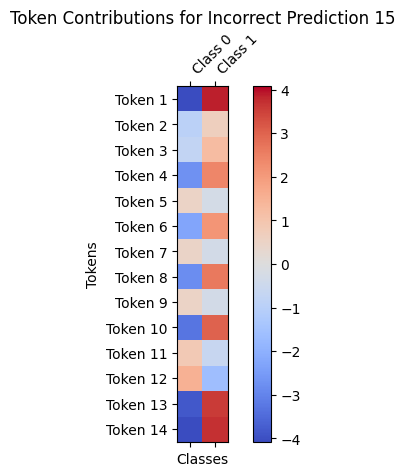

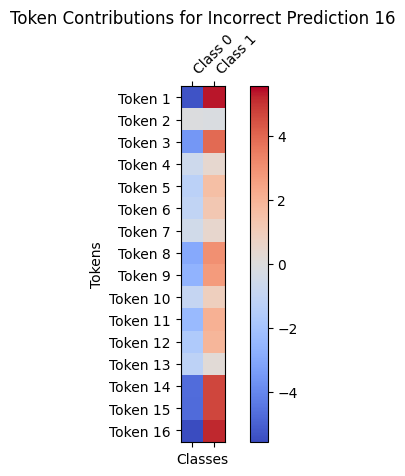

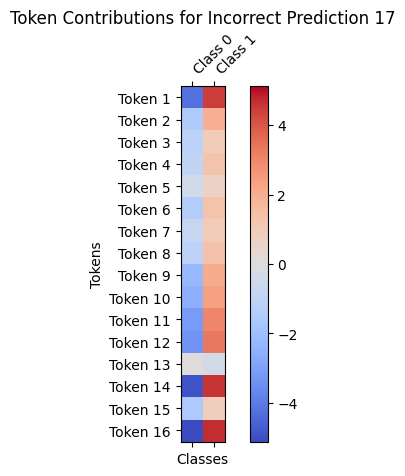

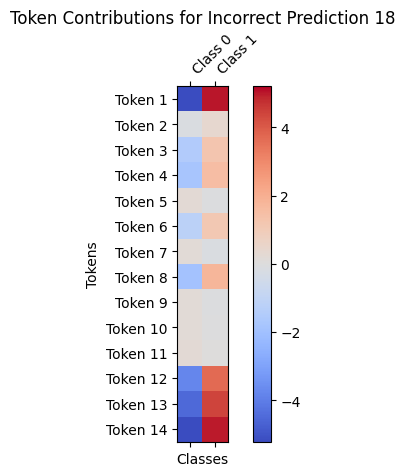

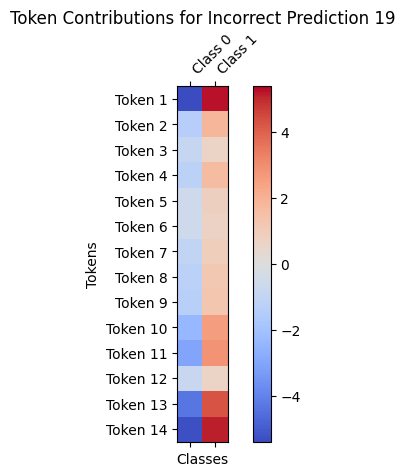

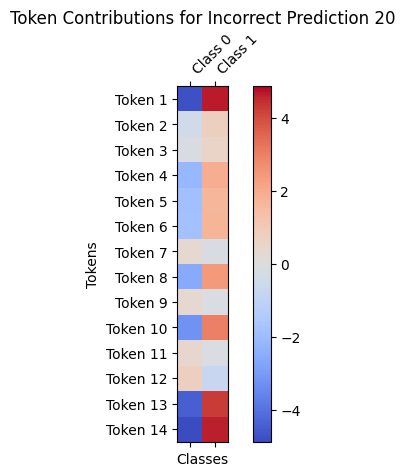

In [8]:

def plot_heatmap(contributions, title):
    """
    Plots a heatmap of the token contributions.

    Args:
        contributions (List[List[float]]): The token contributions for each token in the sequence.
        title (str): The title for the heatmap.
    """
    contributions = np.array(contributions)  # Convert contributions to a NumPy array
    
    vmin = -max(np.abs(contributions.min()), np.abs(contributions.max()))  # Calculate vmin
    vmax = max(np.abs(contributions.min()), np.abs(contributions.max()))  # Calculate vmax

    fig, ax = plt.subplots()
    cax = ax.matshow(contributions, cmap='coolwarm', vmin=vmin, vmax=vmax)
    fig.colorbar(cax)

    ax.set_xticks([0, 1])  # Set x-ticks at the correct positions
    ax.set_xticklabels(['Class 0', 'Class 1'], rotation=45, ha='left')  # Rotate x-tick labels
    
    ax.set_yticks(np.arange(len(contributions)))  # Set y-ticks based on the number of tokens
    ax.set_yticklabels([f'Token {i+1}' for i in range(len(contributions))])  # Set y-tick labels
    #ax.set_xticklabels([''] + ['Class 0', 'Class 1'])
    #ax.set_yticklabels([''] + [f'Token {i+1}' for i in range(len(contributions))])

    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Tokens")
    plt.subplots_adjust(top=0.85)
    plt.show()

 
total_incorrect_plotted = 0  # Counter to keep track of the number of incorrect predictions plotted
max_incorrect_plots = 20  # Maximum number of incorrect predictions to plot

#incorrect_preds = incorrect_predictions(model, test_loader)
for label, incorrect in enumerate(incorrect_preds):
        #print(f"Incorrect predictions for label {label} ({'Valid' if label == 1 else 'Invalid'}):")
        if not incorrect:
            print("No incorrect predictions.")
        else:
            #print(f"Number of incorrect predictions: {len(incorrect)}")
            for i, inp in enumerate(incorrect[20:]):
                if total_incorrect_plotted >= max_incorrect_plots:
                    break
                single_input = torch.tensor(inp)
                contributions = token_contributions(model, single_input)
                plot_heatmap(contributions, title=f"Token Contributions for Incorrect Prediction {total_incorrect_plotted + 1}")
                total_incorrect_plotted += 1
        if total_incorrect_plotted >= max_incorrect_plots:
           break        

#4 Plots Histogram of the Token Contributions for the Given Position

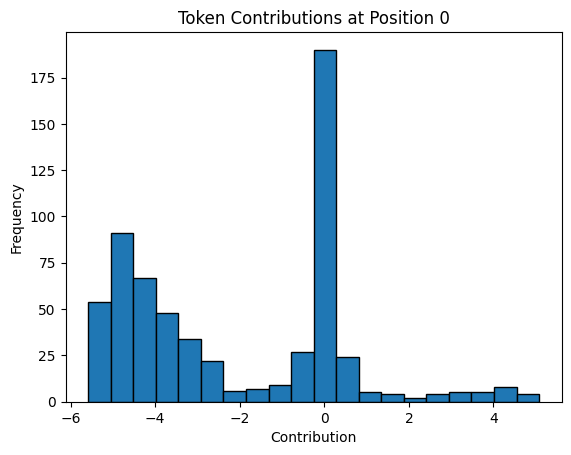

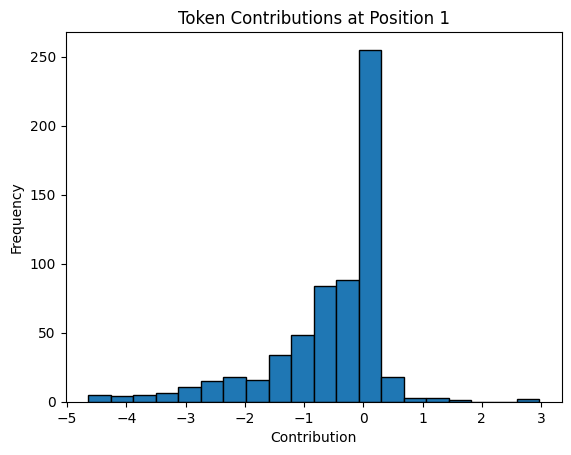

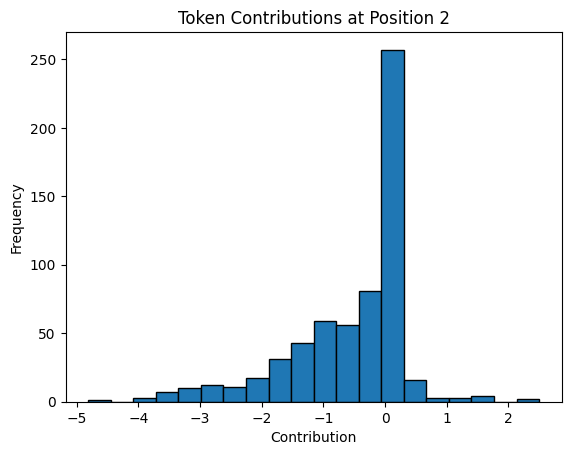

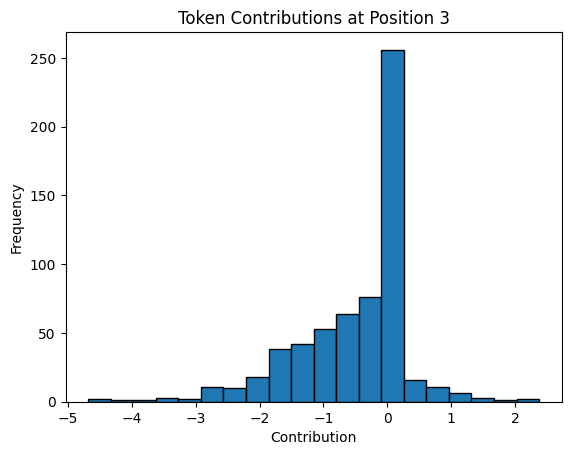

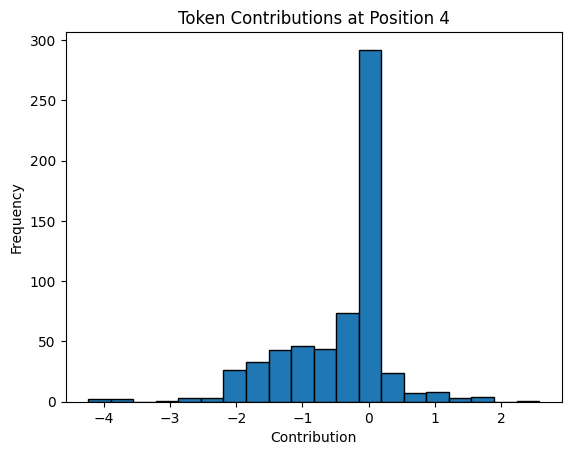

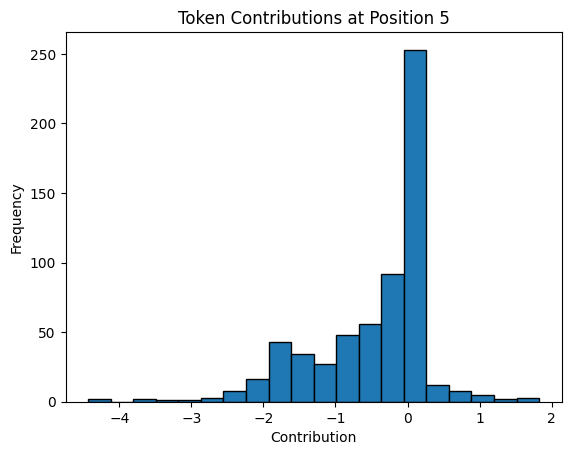

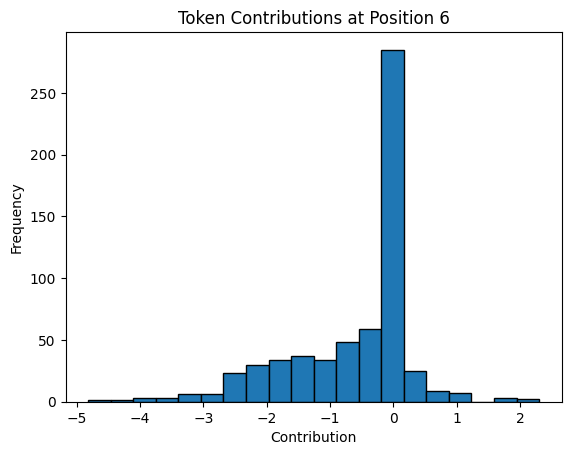

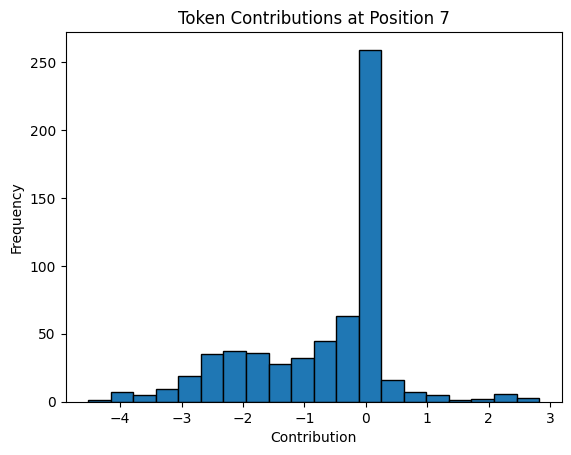

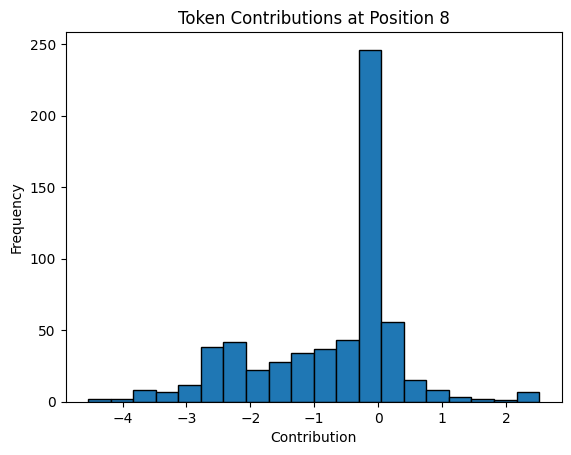

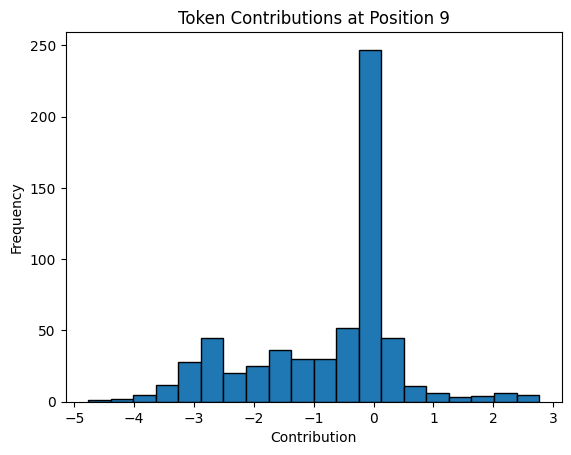

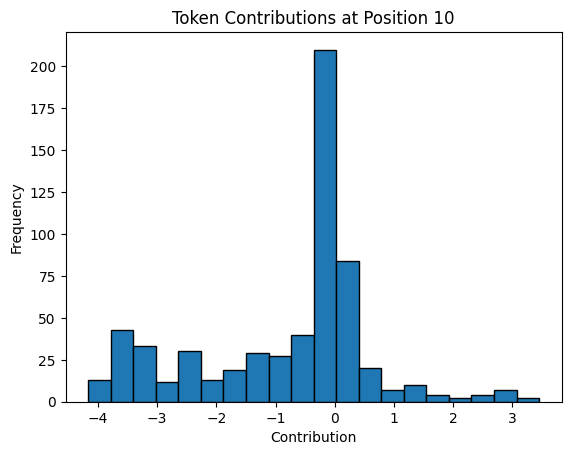

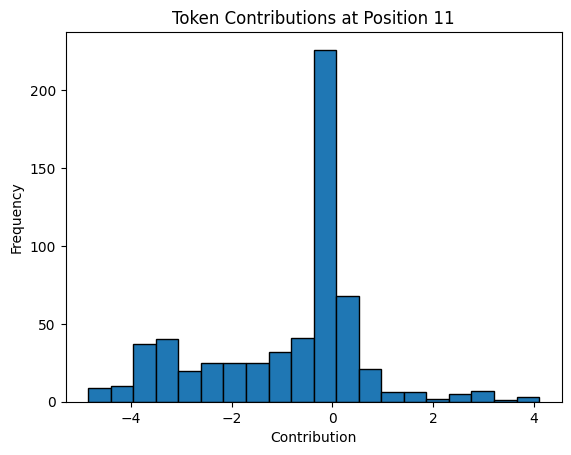

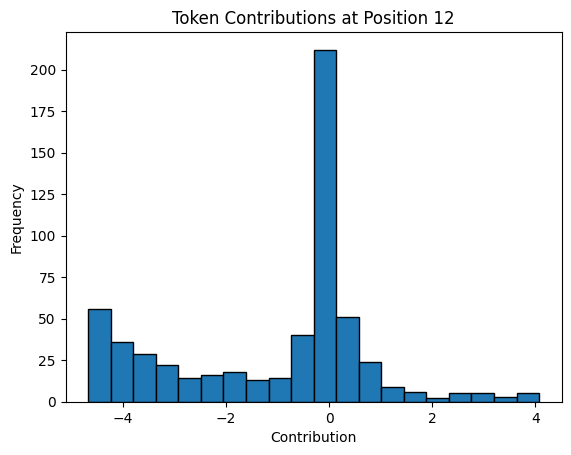

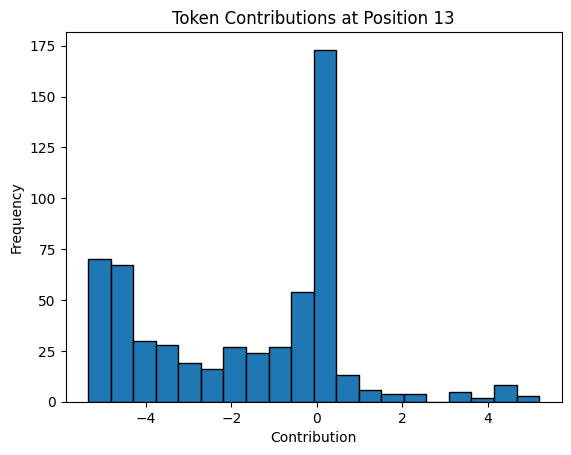

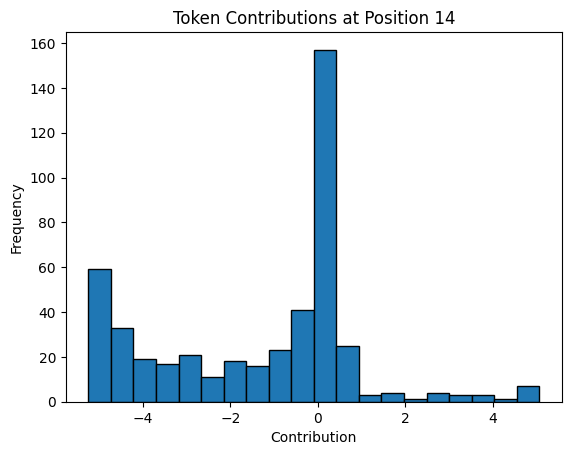

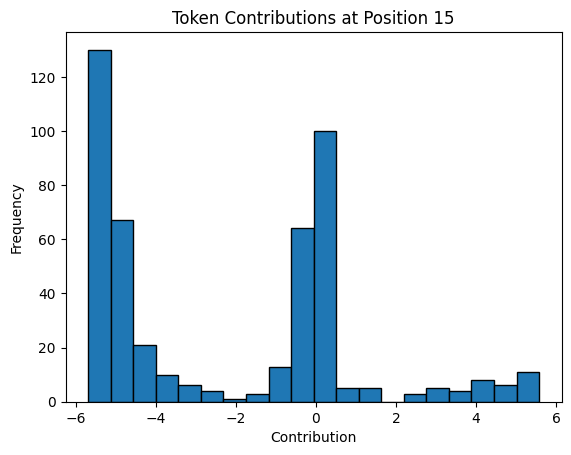

No contributions found for position 16.


In [18]:
#4. For each position from 0 to 21, loop over all inputs in the test set and plot a histogram of the token contributions for that position.

def plot_histogram(data, position):
    """
    Plots a histogram of the contributions for a specific token position.

    Args:
        data (List[float]): The contributions for the specified token position.
        position (int): The token position being analyzed.
    """
    if len(data) == 0:
        print(f"No contributions found for position {position}.")
        return
    
    plt.hist(data, bins=20, edgecolor='black')
    plt.title(f'Token Contributions at Position {position}')
    plt.xlabel('Contribution')
    plt.ylabel('Frequency')
    plt.show()


for position in range(17):
        contributions_at_position = []

        # Loop over all inputs in the test set
        for inputs, labels in test_loader:
            inputs = inputs

            for i in range(inputs.size(0)):
                single_input = inputs[i]
                contributions = token_contributions(model, single_input)

                if position < len(contributions):
                    contributions_at_position.append(contributions[position][0])  # Assuming class 0 contributions
                #else:
                     #print(f"skipping contributions for position {position} for input sequence of length {len(contributions)}")    
        # Plot the histogram for the current position
        #print(f"Total contributions collected for position {position}: {len(contributions_at_position)}")
        plot_histogram(contributions_at_position, position)



#5 Plots the Heatmap for the Projection Layer and the Second Linear Layer in the Feedforward.

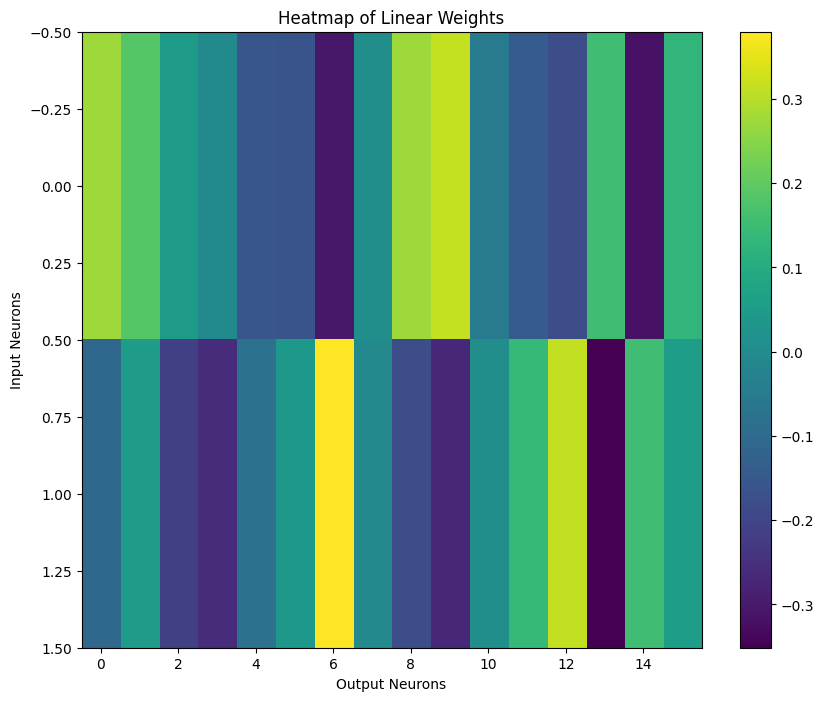

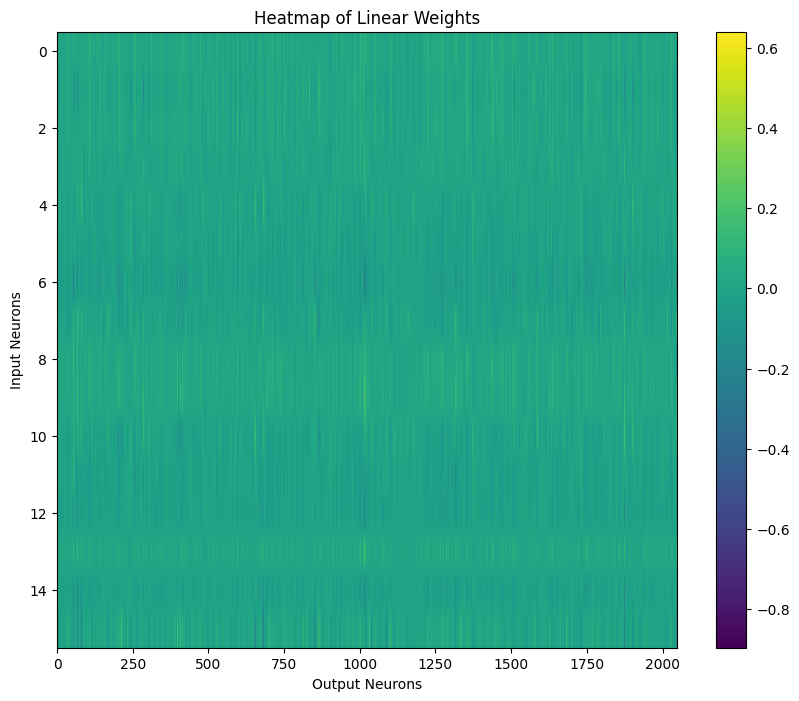

In [9]:
#5. Plot the heatmap for the projection layer and the second linear layer in the feedforward.
plot_linear_layer(model.proj)

 
plot_linear_layer(model.encoder.layers[0].linear2)

#6 Plots Histogram of the activations as a histogram

Total number of activations collected: 32
Sample activations: [[0, 0, 10, 10, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 10, 0, 10, 10, 10, 0, 0, 0, 0, 10, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 10, 0, 10, 0, 0, 10, 0, 0, 10, 10, 0, 0, 0, 10, 10, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 10, 10, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 0, 10, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 0, 0, 0, 10, 10, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 10, 10, 0, 10, 10, 10, 10, 0, 10, 0, 10, 10, 0, 10, 0, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 10, 0, 0, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 10, 0, 0, 0, 0, 0, 10, 10, 0, 0, 0, 0, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 10, 0, 10, 0, 0, 10, 0, 0, 10, 0, 10, 0, 0, 0, 0, 0, 10, 10, 0, 10, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 10, 10, 0, 10, 0, 0, 0, 

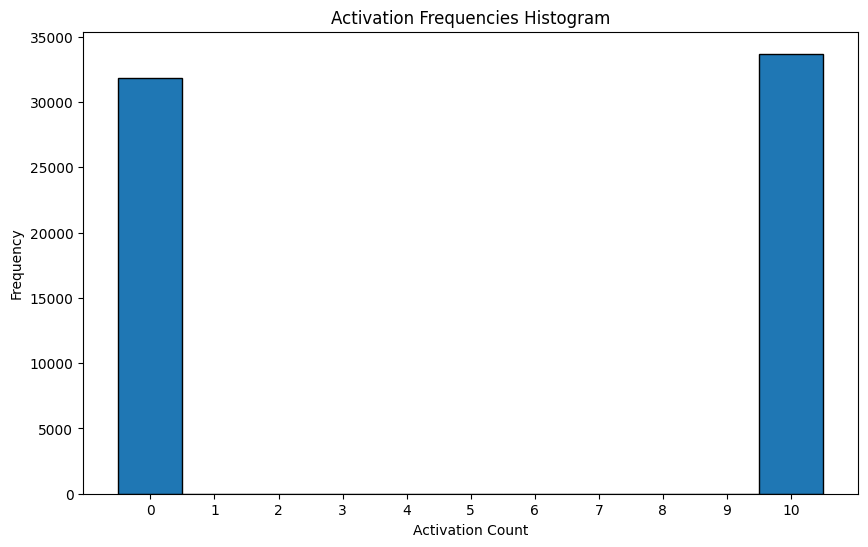

In [14]:
#Loop over all inputs in the test set and count the activations in the feedforward layer. Plot the activations as a histogram to see which features in the feedforward layer are activated the most.

# Compute and print the activations
activations = collect_activations(model, test_loader)
#print("Feedforward Layer Activations (summary):")
#print(f"Total collected activations: {len(activations)}")
#print(f"Sample of collected activations: {activations[:10]}")
print("Collected Activations:", activations)

def plot_activation_histogram(frequencies, title="Activation Frequencies Histogram"):
    print("Plotting histogram...")
    print(f"Frequencies: {frequencies[:10]}")  # Print the first 10 frequencies as a sample
    plt.figure(figsize=(10, 6))
    # Use bins with correct range
    if frequencies:
        if any(isinstance(i, list) for i in frequencies):  # Check if there are nested lists
            print("Frequencies contain nested lists. Flattening the list.")
            frequencies = [item for sublist in frequencies for item in sublist]  # Flatten the list of lists
        print(f"Flattened Frequencies: {frequencies[:10]}")  # Print the first 10 frequencies as a sample
        bins = np.arange(0, max(frequencies) + 2) - 0.5
        plt.hist(frequencies, bins=bins, edgecolor='black')
        plt.xlabel('Activation Count')
        plt.ylabel('Frequency')
        plt.title(title)
        plt.xticks(np.arange(0, max(frequencies) + 1, step=1))
        plt.show()
    else:
        print("No frequencies to plot.")


plot_activation_histogram(activations)